# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#tf.__version__

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 
print(DATA_LIST)

['covid', 'normal']


#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [55]:
# raise NotImplementedError("Build your model based on an architecture of your choice "
#                           "A sample model summary is shown below")
#print(DATA_LIST)
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Input
from tensorflow.keras.models import Model


base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

head_model = base_model.output
head_model = tf.keras.layers.AveragePooling2D(pool_size=(4,4))(head_model)
head_model = tf.keras.layers.Flatten(name="flatten")(head_model)
head_model = tf.keras.layers.Dense(64, activation="relu", name="feature_dense")(head_model)
head_model = tf.keras.layers.Dropout(0.3)(head_model)
head_model = tf.keras.layers.Dense(1)(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

#print(len(base_model.layers)) #Base Model has 19 Layers
fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
#the base model architecture
model.summary()

Model: "functional_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

#### [5 points] Train Model

In [56]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

# raise NotImplementedError("Use the model.fit function to train your network")
initial_epochs = 40
history = model.fit(x = train_batches,
                    epochs=initial_epochs,
                    validation_data=valid_batches, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID)


11
3


D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
10/10 [==============================] - 8s 784ms/step - loss: 0.7158 - accuracy: 0.5638 - val_loss: 0.5809 - val_accuracy: 0.7000
Epoch 2/40
10/10 [==============================] - 8s 838ms/step - loss: 0.4838 - accuracy: 0.7553 - val_loss: 0.3155 - val_accuracy: 0.8500
Epoch 3/40
10/10 [==============================] - 9s 889ms/step - loss: 0.3602 - accuracy: 0.8617 - val_loss: 0.1782 - val_accuracy: 0.9000
Epoch 4/40
10/10 [==============================] - 9s 920ms/step - loss: 0.2807 - accuracy: 0.8800 - val_loss: 0.3648 - val_accuracy: 0.8000
Epoch 5/40
10/10 [==============================] - 8s 840ms/step - loss: 0.3113 - accuracy: 0.9255 - val_loss: 0.2384 - val_accuracy: 0.9000
Epoch 6/40
10/10 [==============================] - 8s 843ms/step - loss: 0.3185 - accuracy: 0.8936 - val_loss: 0.2596 - val_accuracy: 0.9000
Epoch 7/40
10/10 [==============================] - 9s 908ms/step - loss: 0.4643 - accuracy: 0.8000 - val_loss: 0.2359 - val_accuracy: 0.8000
Epoch 

#### [5 points] Plot Accuracy and Loss During Training

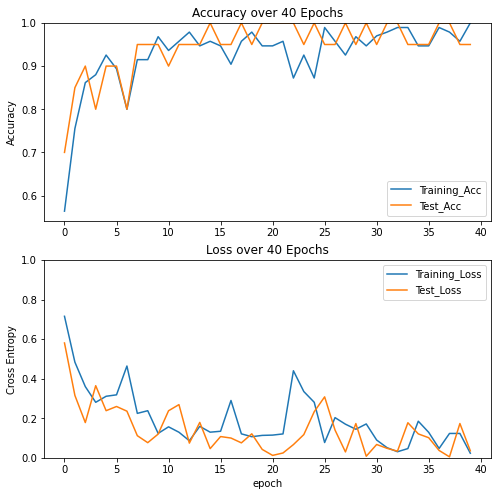

In [57]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training_Acc')
plt.plot(val_acc, label='Test_Acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy over %s Epochs' % initial_epochs)


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training_Loss')
plt.plot(val_loss, label='Test_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Loss over %s Epochs'% initial_epochs)
plt.xlabel('epoch')
plt.show()

#### Plot Test Results

Found 18 images belonging to 2 classes.
18/18 [==============================] - 2s 114ms/step
covid\nejmoa2001191_f3-PA.jpeg


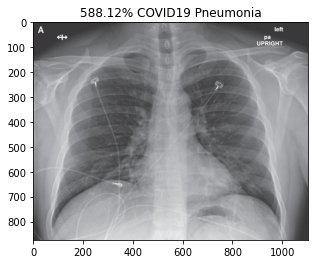

covid\nejmoa2001191_f4.jpeg


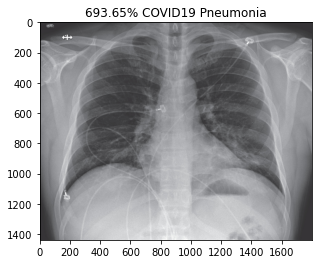

covid\nejmoa2001191_f5-PA.jpeg


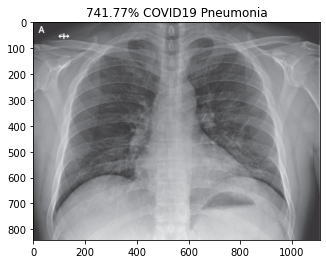

covid\radiol.2020200490.fig3.jpeg


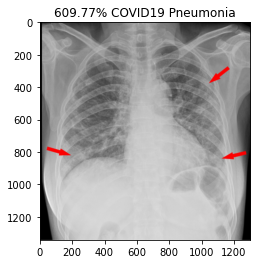

covid\ryct.2020200028.fig1a.jpeg


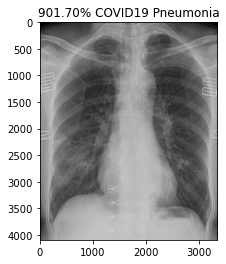

covid\ryct.2020200034.fig2.jpeg


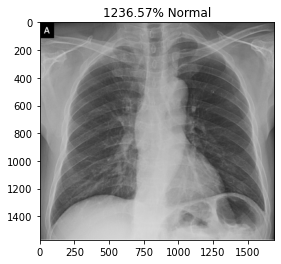

covid\ryct.2020200034.fig5-day0.jpeg


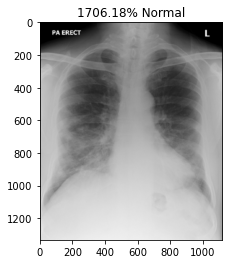

covid\ryct.2020200034.fig5-day4.jpeg


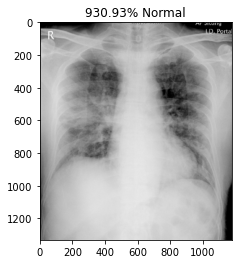

covid\ryct.2020200034.fig5-day7.jpeg


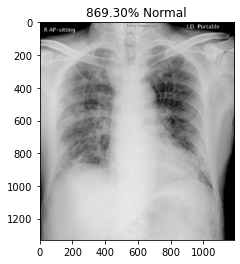

normal\NORMAL2-IM-1385-0001.jpeg


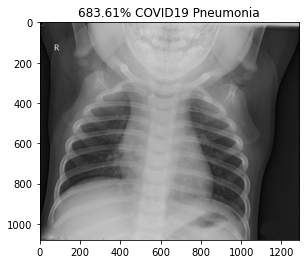

normal\NORMAL2-IM-1396-0001.jpeg


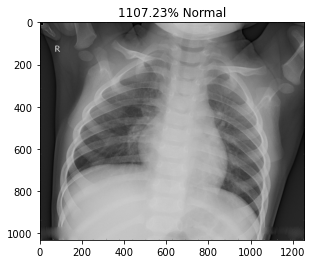

normal\NORMAL2-IM-1400-0001.jpeg


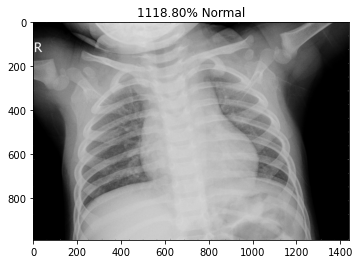

normal\NORMAL2-IM-1401-0001.jpeg


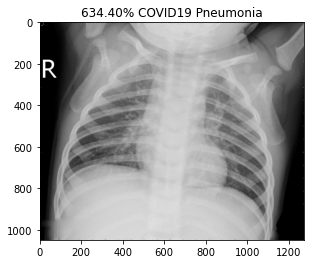

normal\NORMAL2-IM-1406-0001.jpeg


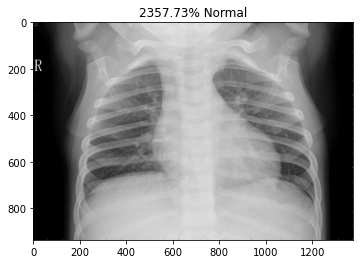

normal\NORMAL2-IM-1412-0001.jpeg


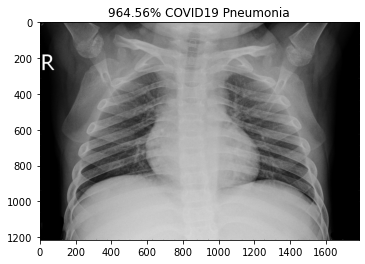

normal\NORMAL2-IM-1419-0001.jpeg


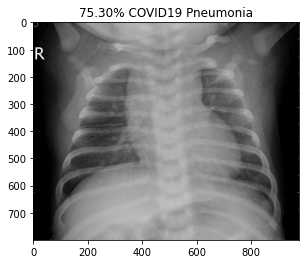

normal\NORMAL2-IM-1422-0001.jpeg


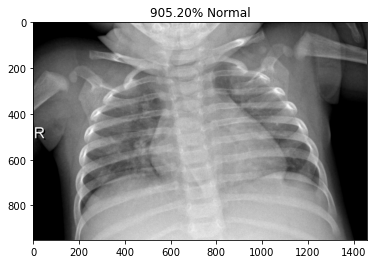

normal\NORMAL2-IM-1423-0001.jpeg


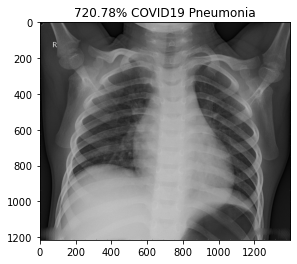

In [58]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 130 images belonging to 2 classes.


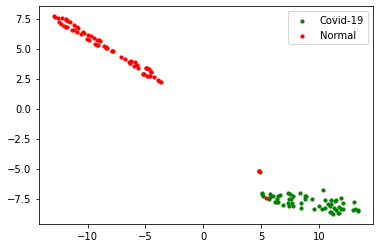

In [62]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the four classes.")
features = intermediate_layer_model.predict(tsne_eval_generator)
label = tsne_eval_generator.class_indices

classes = tsne_eval_generator.classes
fea_tsne = TSNE(learning_rate=50).fit_transform(features)
X,Y = zip(*fea_tsne)

X_Nor=[]
Y_Nor=[]

X_Cov=[]
Y_Cov=[]

for x,y,c in zip(X,Y,classes):
    if(label['covid']==c):
        X_Cov.append(x)
        Y_Cov.append(y)
    else:
        X_Nor.append(x)
        Y_Nor.append(y)

plt.scatter(X_Cov, Y_Cov, c='green', label='Covid-19', s=10)
plt.scatter(X_Nor, Y_Nor, c='red', label='Normal', s=10)

plt.legend()
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->